In [6]:
import oyaml as yaml
import glob
import zdb

In [7]:
cfg = {
    "query": {
        "groupby": ["table", "varname0", "selection", "parent", "binvar0"],
        "tables": {"central": "Events"},
        "aliases": {},
        "eval": [
            {"GenPartBoson_pt_bin": 'df: np.floor(df.GenPartBoson_pt/5.)*5'},
        ],
        "cutflows": {
            "NLOQCD": {
                "selection_name": "NLOQCD",
                "selection": "GenPartBoson_pt>=0.",
                "weight": "df.WeightXsLumi*df.WeightPU",
                "hists": ["GenPartBoson_pt"],
            },
            "NLOQCDnNLOEWK": {
                "selection_name": "NLOQCDnNLOEWK",
                "selection": "GenPartBoson_pt>=0.",
                "weight": "df.WeightXsLumi*df.WeightPU*df.K_NLOQCD_NLOQCDnNLOEWK",
                "hists": ["GenPartBoson_pt"],
            },
            "NNLOQCD": {
                "selection_name": "NNLOQCD",
                "selection": "GenPartBoson_pt>=0.",
                "weight": "df.WeightXsLumi*df.WeightPU*df.K_NLOQCD_NNLOQCD",
                "hists": ["GenPartBoson_pt"],
            },
            "NNLOQCDnNLOEWK": {
                "selection_name": "NNLOQCDnNLOEWK",
                "selection": "GenPartBoson_pt>=0.",
                "weight": "df.WeightXsLumi*df.WeightPU*df.K_NLOQCD_NNLOQCDnNLOEWK",
                "hists": ["GenPartBoson_pt"],
            },
        },
        "hists": {
            "GenPartBoson_pt": [
                {"table": "df: '{table_name}'"},
                {"varname0": "df: 'GenPartBoson_pt'"},
                {"selection": "df: '{selection_name}'"},
                {"parent": "df: df.parent"},
                {"binvar0": "df: df.GenPartBoson_pt_bin"},
                {"count": "df: 1."},
                {"sum_w": "df: {weight}"},
                {"sum_ww": "df: df.sum_w**2"},
            ],
        },
    },
    "files": sorted(list(glob.glob("/vols/cms/sdb15/Analysis/ZinvWidth/databases/2019/11_Nov/11_HigherOrderCorrections/*.h5"))),
}

with open("configs/hists/mc.yaml", 'w') as f:
    yaml.dump(cfg, f, indent=4)

In [5]:
zdb.modules.analyse(
    "configs/hists/mc.yaml",
    mode="sge",
    ncores=-1,
    batch_opts='-q hep.q -l h_vmem=12G',
    output="data/hists.yaml:MCAggEvents",
    merge_opts={"mode": "sge", "ncores": 25, "batch_opts": '-q hep.q'},
)

2019-11-13 09:56:40,112 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/phd/ZinvWidth/zinv-notebooks/notebooks/zinv/0_generate_tables/higher_order_corrections/_ccsp_temp/tpd_20191113_095640_lvq9lkcn


2019-11-13 09:56:46,069 - pysge.submitter - INFO - Submitted 7203623.1-459:1


2019-11-13 09:58:34,182 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/phd/ZinvWidth/zinv-notebooks/notebooks/zinv/0_generate_tables/higher_order_corrections/_ccsp_temp/tpd_20191113_095834_p6ho7n33


2019-11-13 09:58:34,631 - pysge.submitter - INFO - Submitted 7203624.1-25:1


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dftools

Welcome to JupyROOT 6.18/00


In [31]:
plt.style.use("cms")

In [18]:
df = pd.read_hdf("data/hists.yaml", "MCAggEvents")
df.index.get_level_values("selection").unique()

Index(['NLOQCD', 'NLOQCDnNLOEWK', 'NNLOQCD', 'NNLOQCDnNLOEWK'], dtype='object', name='selection')

In [76]:
def draw(df, bins, ax=None, **kwargs):
    if ax is None:
        ax = plt.axes()
        
    ax.hist(
        bins,
        bins = list(bins) + [2*bins[-1]-bins[-2]],
        weights = df["sum_w"],
        **kwargs,
    )
    
    ax.set_xlim(bins[0], 2*bins[-1]-bins[-2])
    
    return ax

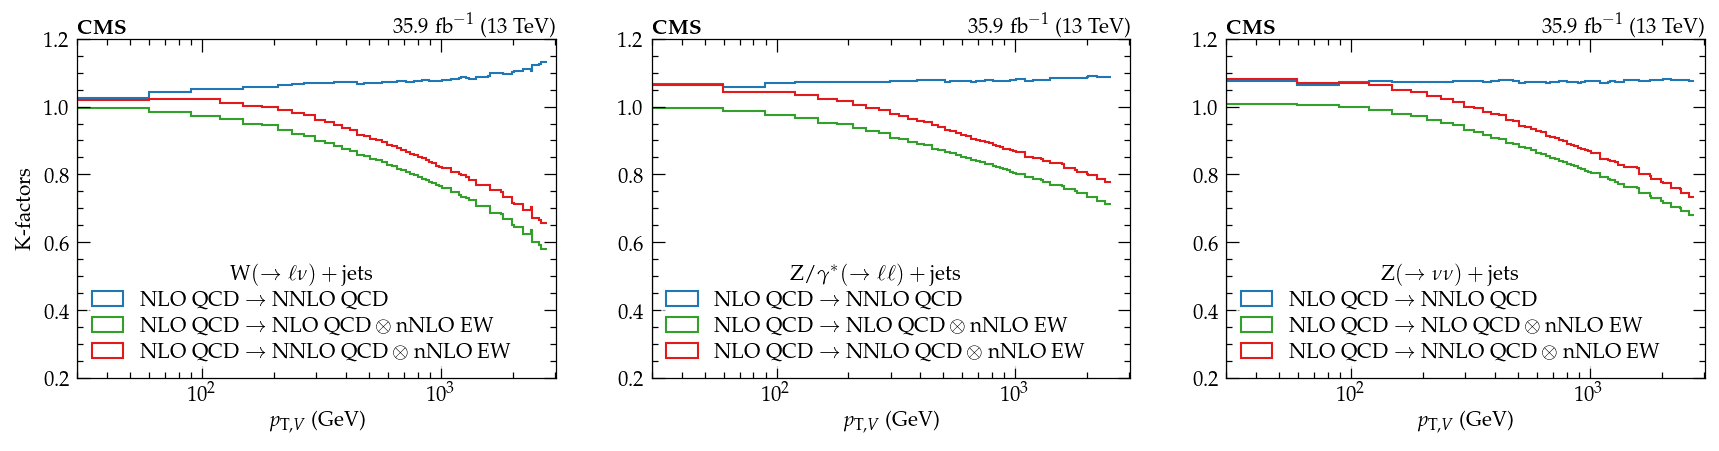

In [80]:
fig, ax = plt.subplots(
    figsize=(14, 3), dpi=150,
    ncols=3,
)
bins = np.linspace(30., 3000., 101)

vjets = "WJetsToLNu"
num = df.loc[("central", "GenPartBoson_pt", "NLOQCD", vjets),:]
den = df.loc[("central", "GenPartBoson_pt", "NNLOQCD", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[0], histtype='step', color='#1f78b4', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NNLO\ QCD}$')

den = df.loc[("central", "GenPartBoson_pt", "NLOQCDnNLOEWK", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[0], histtype='step', color='#33a02c', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NLO\ QCD}\otimes\mathrm{nNLO\ EW}$')

den = df.loc[("central", "GenPartBoson_pt", "NNLOQCDnNLOEWK", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[0], histtype='step', color='#e31a1c', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NNLO\ QCD}\otimes\mathrm{nNLO\ EW}$')

ax[0].set_ylim(0.8, 1.8)
ax[0].legend(loc=3, title=r'$\mathrm{W}(\rightarrow\ell\nu)+\mathrm{jets}$', borderpad=0.2, labelspacing=0.2)

dftools.draw.cms_label(ax[0], '')
ax[0].set_xlabel(r'$p_{\mathrm{T},V}$ (GeV)')
ax[0].set_ylabel(r'K-factors')


vjets = "DYJetsToLL"
num = df.loc[("central", "GenPartBoson_pt", "NLOQCD", vjets),:]
den = df.loc[("central", "GenPartBoson_pt", "NNLOQCD", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[1], histtype='step', color='#1f78b4', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NNLO\ QCD}$')

den = df.loc[("central", "GenPartBoson_pt", "NLOQCDnNLOEWK", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[1], histtype='step', color='#33a02c', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NLO\ QCD}\otimes\mathrm{nNLO\ EW}$')

den = df.loc[("central", "GenPartBoson_pt", "NNLOQCDnNLOEWK", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[1], histtype='step', color='#e31a1c', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NNLO\ QCD}\otimes\mathrm{nNLO\ EW}$')

ax[1].legend(loc=3, title=r'$\mathrm{Z}/\gamma^{*}(\rightarrow\ell\ell)+\mathrm{jets}$', borderpad=0.2, labelspacing=0.2)

dftools.draw.cms_label(ax[1], '')
ax[1].set_xlabel(r'$p_{\mathrm{T},V}$ (GeV)')


vjets = "ZJetsToNuNu"
num = df.loc[("central", "GenPartBoson_pt", "NLOQCD", vjets),:]
den = df.loc[("central", "GenPartBoson_pt", "NNLOQCD", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[2], histtype='step', color='#1f78b4', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NNLO\ QCD}$')

den = df.loc[("central", "GenPartBoson_pt", "NLOQCDnNLOEWK", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[2], histtype='step', color='#33a02c', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NLO\ QCD}\otimes\mathrm{nNLO\ EW}$')

den = df.loc[("central", "GenPartBoson_pt", "NNLOQCDnNLOEWK", vjets),:]
num = dftools.transform.rebin(num, bins=bins, label="binvar0")
den = dftools.transform.rebin(den, bins=bins, label="binvar0")
ratio = den/num
draw(ratio, bins, ax=ax[2], histtype='step', color='#e31a1c', label=r'$\mathrm{NLO\ QCD}\rightarrow\mathrm{NNLO\ QCD}\otimes\mathrm{nNLO\ EW}$')

ax[2].legend(loc=3, title=r'$\mathrm{Z}(\rightarrow\nu\nu)+\mathrm{jets}$', borderpad=0.2, labelspacing=0.2)

dftools.draw.cms_label(ax[2], '')
ax[2].set_xlabel(r'$p_{\mathrm{T},V}$ (GeV)')

ylim = (0.2, 1.2)
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')

Help on function rebin in module dftools.transform:

rebin(df, bins, label='binvar0', underflow=True, overflow=True)
    Take a dataframe with the 'label' as an index and rebin/densify into the
    input bins returning a new dataframe.
    
    Parameters
    ----------
    df : DataFrame-like
        Dataframe with index `label` which will be rebinned (and densified)
        into a new set of bins.
    
    bins : ndarray-like
        The bins to rebin into.
    
    label : str (default, binvar0)
        The index label to rebin. Other indexes are left alone.
    
    underflow : bool (default, True)
        Include underflow entires in the lowest bin
    
    overflow : bool (default, True)
        Include overflow entries in the highest bin

